## Setup

### Variables to Edit

In [1]:
# enums
NORMAL, CATARACTS, MILD_AMBLYOPIA, MULTIPLE_SCLEROSIS = ['Normal', 'Cataracts', 'Mild Amblyopia', 'Multiple Sclerosis']

##################
# CUSTOMIZE HERE #
##################

# tasks and number of latents
phenotypes = [NORMAL, NORMAL]
num_latents = 2
sampling_method = 'alternating'     # 'alternating' or 'unconstrained'
weight_decay = 1e-4

# choose to run multiple experiments with preset random seeds
# or a single experiment specifying your own random seeds
run_multiple_experiments = False

if run_multiple_experiments:
    num_exps = 25
    # random seeds generated automatically
    # as [[0, 1], [2, 3], ... [2n, 2n+1]] for generating primer labels
    # and [0, ..., n-1] for starting the training loop
else:
    primer_random_seeds = [0, 0]
    gp_random_seed = 0
    # num_exps set to 1 later if running single round

# number of samples
num_halton_samples_per_task = 2
num_new_pts_per_task = 48


# runtime flags
train_mode = True
verbose_mode = True         # print verbose analyses?
scrn_mode = True            # plot on screen?
save_results_mode = True    # save results to file?
save_plots_mode = True      # save plots to directory?

# choosing which figures to make
make_gp_gifs = True
make_entropy_gifs = False
make_hyper_plots = True


# directory to save plots and results
# will save to the path <save_dir_prefix>/<current_timestamp>
save_dir_prefix = 'analysis/Figure02'

# Individual print flags 
print_training_hyperparameters = False
print_training_iters = False
print_progress_bar = False

# Set all to true if verbose_mode
if verbose_mode:
    print_training_hyperparameters = False
    print_training_iters = True
    print_progress_bar = False

### Imports

In [2]:
# Import libraries
import os
import sys
import torch
import gpytorch as gp

import math
import numpy as np

import datetime
import json
import pickle
import tqdm

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import seaborn as sns

# need access to root directory to import utils
parent_dir = os.path.dirname(os.path.abspath(''))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from utility.utils import *

Check versions of python, Gpytorch, and Pytorch dependencies

In [3]:
print("python version -->>", sys.version.split(" ")[0], "(expected 3.10.9)")
print("gpytorch version -->>", gp.__version__, "(expected 1.8.1)")
print("pytorch version -->>", torch.__version__, "(expected 1.13.1)")

python version -->> 3.10.9 (expected 3.10.9)
gpytorch version -->> 1.8.1 (expected 1.8.1)
pytorch version -->> 1.13.1 (expected 1.13.1)


### Misc Variables

In [4]:
# Constant Declarations
subplots_adjust_params = {
    'bottom':0.1, 
    'top':0.9, 
    'left':0.1, 
    'right':0.8, 
    'wspace':0.05, 
    'hspace':0.3
}
cax_location_params = [0.84, 0.1, 0.02, 0.8] # [left, bottom, width, height]

# Create the bounds for the data
raw_freq_min = 1
raw_freq_max = 64
raw_contrast_min = 1e-3
raw_contrast_max = 1

# Define how to transform the data
x_min = logFreq().forward(raw_freq_min)
x_max = logFreq().forward(raw_freq_max)
y_min = logContrast().forward(raw_contrast_max)  # max and min get flipped when inverting
y_max = logContrast().forward(raw_contrast_min)

# transform the data
def normalize_to_unit_range(d):
    return scale_data_within_range(d, (0, 1), x_min, x_max, y_min, y_max)

# marginal log resolutions of evaulation grid
x_resolution = 15  # 15 spatial frequencies per octave
y_resolution = 30  # 30 contrast units per decade

# for computing the proper prior threshold curve
psi_gamma  = 0.04  # guess rate is 4%
psi_lambda = 0.04 # lapse rate is 4%
psi_sigma = 0.08
sigmoid_type = 'logistic'

# training parameters?
num_initial_points_training_iters = 500
num_new_points_training_iters = 150
train_on_all_points_iters = 1500
sampling_strategy = 'active'
mean_module = 'constant_mean'
train_on_all_points_after_sampling = False
calculate_rmse = True
calculate_posterior = True
calculate_entropy = True

# GP hyperparameters?
learning_rate = .125
beta_for_regularization = .5
min_lengthscale = .15 # Note this changed from .2


# Set raw ghost points 
raw_ghost_frequency = np.array([1, 2, 4, 8, 16, 32, 64, 128])
raw_ghost_contrast = np.array([5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 1])


In [5]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prepare Data

### Get Data

In [6]:
# get data selection
exp1_file = '../data/raw/csf_curves_exp1.json'
csf_curves_exp1 = load_json_from_file(exp1_file)
all_phenotypes = {MULTIPLE_SCLEROSIS: csf_curves_exp1['multiple_sclerosis'],
             CATARACTS: csf_curves_exp1['cataracts'],
             NORMAL: csf_curves_exp1['normal'],
             MILD_AMBLYOPIA: csf_curves_exp1['mild_amblyopia']}

all_pairs_names = [
    (NORMAL, NORMAL),
    (NORMAL, CATARACTS),
    (NORMAL, MILD_AMBLYOPIA),
    (NORMAL, MULTIPLE_SCLEROSIS),
    (CATARACTS, CATARACTS),
    (CATARACTS, MILD_AMBLYOPIA),
    (CATARACTS, MULTIPLE_SCLEROSIS),
    (MILD_AMBLYOPIA, MILD_AMBLYOPIA),
    (MILD_AMBLYOPIA, MULTIPLE_SCLEROSIS),
    (MULTIPLE_SCLEROSIS, MULTIPLE_SCLEROSIS),
]

all_pairs_names_and_curves = [[(name, all_phenotypes[name]) for name in pair] for pair in all_pairs_names]
# phenotype_pair = [(pheno, all_phenotypes[pheno]) for pheno in phenotypes]

### Set Timestamp to Save To

In [7]:
# get current timestamp
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_dir = f"{save_dir_prefix}/{timestamp}/"
ensure_directory_exists(save_dir)
print(f"Saving to... {save_dir}")

Saving to... analysis/Figure02/2024-06-22_13-50-08/


### Calculate Common Variables

In [8]:
# create common variables shared among all tasks
grid, xx, yy, xs, ys = create_evaluation_grid_resolution(
        x_min, x_max, y_min, y_max, x_resolution, y_resolution)

grid_transformed = transform_dataset(grid, phi=normalize_to_unit_range)

# function to get ground truth curves
def get_spline(curve):
    curve = np.array(curve)
    curve[:, 0] = (np.log2(10) * curve[:, 0]) - np.log2(.125)
    cs = create_cubic_spline(curve)
    return cs

num_tasks = len(all_pairs_names_and_curves[0])

all_ground_truths = {pair:[get_spline(all_phenotypes[name]) for name in pair] for pair in all_pairs_names}

# get number of actively learned points for disjoint vs conjoint
num_pts_per_task = num_new_pts_per_task + num_halton_samples_per_task
num_new_conjoint_pts = num_new_pts_per_task * num_tasks
num_conjoint_pts = num_pts_per_task * num_tasks

In [9]:
# create ghost points and labels
ghost_x1 = logFreq().forward(raw_ghost_frequency)
ghost_x2 = logContrast().forward(raw_ghost_contrast)
assert len(ghost_x1) == len(ghost_x2), "x1 and x2 have diff lengths"

ghost_X = np.vstack((ghost_x1, ghost_x2)).T
ghost_y = np.array([0]*len(ghost_x2))

# create disjoint initial primer points
halton_X = get_halton_samples(xx, yy, num_halton_samples_per_task)
initial_disjoint_X = np.vstack((ghost_X, halton_X))

# create conjoint initial primer points and task indices
# simulated Halton y labels are created later for each experiment
halton_Xs = np.repeat(halton_X, num_tasks, axis=0)

num_ghost_points_per_task = len(ghost_y)
halton_task_indices = torch.arange(num_tasks).tile((num_halton_samples_per_task))

ghost_Xs = np.tile(ghost_X, (num_tasks, 1))
ghost_ys = np.tile(ghost_y, num_tasks)
ghost_task_indices = torch.arange(num_tasks).repeat_interleave(num_ghost_points_per_task)

num_disjoint_ghost_points = len(ghost_x2)
num_conjoint_ghost_points = len(ghost_task_indices)

# create initial dataset using ghost and halton samples
initial_Xs = np.vstack((ghost_Xs, halton_Xs))
initial_task_indices = torch.cat((ghost_task_indices, halton_task_indices))

### Configure Multiple vs Single Experiments

In [10]:
# random seed lists for single vs multiple rounds
if run_multiple_experiments:
    # unique random seeds for halton samples and training
    primer_seeds_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_exps)]
    gp_seed_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_exps)]
else:
    num_exps = 1
    primer_seeds_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_exps)]
    gp_seed_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_exps)]

### Save Run Info to JSON

In [11]:
figure_dict = {
    "all_pairs_names": all_pairs_names,
    "tasks": phenotypes,
    "num_latents": num_latents,
    "sampling_method": sampling_method,
    "num_exps": num_exps,
    "num_halton_samples_per_task": num_halton_samples_per_task,
    "num_new_pts_per_task": num_new_pts_per_task,
    "raw_freq_min": raw_freq_min,
    "raw_freq_max": raw_freq_max,
    "raw_contrast_min": raw_contrast_min,
    "raw_contrast_max": raw_contrast_max,
    "x_resolution": x_resolution,
    "y_resolution": y_resolution,
    "raw_ghost_frequency": raw_ghost_frequency.tolist(),
    "raw_ghost_contrast": raw_ghost_contrast.tolist(),
    "primer_seeds_list": primer_seeds_list,
    "gp_seed_list": gp_seed_list,
    "weight_decay": weight_decay,
    "min_lengthscale": min_lengthscale,
    "psi_sigma": psi_sigma,
    "sigmoid_type": sigmoid_type,
    "psi_gamma": psi_gamma,
    "psi_lambda": psi_lambda,
    "lr": learning_rate,
    "num_initial_training_iters": num_initial_points_training_iters,
    "num_new_points_training_iters": num_new_points_training_iters,
    "beta_for_regularization": beta_for_regularization,
    "train_on_all_points_after_sampling": train_on_all_points_after_sampling,
    "print_training_hyperparameters": print_training_hyperparameters,
    "print_training_iters": print_training_iters,
    "progress_bar": print_progress_bar,
    "calculate_rmse": calculate_rmse,
    "calculate_entropy": calculate_entropy,
    "calculate_posterior": calculate_posterior
}

ensure_directory_exists(save_dir)
with open(save_dir + "run_configs.json", 'w') as file:
    json.dump(figure_dict, file, indent=2)

## Model Training

### Disjoint

In [12]:
all_disjoint_results_dicts_old = {pair:[{} for _ in range(num_tasks)] for pair in all_pairs_names}
all_disjoint_gp_lists_old = {pair:[] for pair in all_pairs_names}

if train_mode:
    for exp in range(num_exps):
        for pair_names_and_curves in all_pairs_names_and_curves:
            pair_names = (pair_names_and_curves[0][0], pair_names_and_curves[1][0])
            print(pair_names)
            disjoint_results_dicts_old = all_disjoint_results_dicts_old[pair_names]
            disjoint_gp_lists_old = all_disjoint_gp_lists_old[pair_names]
            pair_dir = '__'.join(pair_names).replace(' ', '_')
            
            print(f"Experiment {exp}")
        
            # get unique random seeds for each exp
            primer_seeds = primer_seeds_list[exp]
            gp_seeds = gp_seed_list[exp]
        
            # get unique halton labels for each experiment
            halton_y_list = []
            
            for i, (pheno, pheno_data) in enumerate(pair_names_and_curves):
                print(pheno)
                
                cs = all_ground_truths[pair_names][i]
                primer_seed = primer_seeds[i]
                gp_seed = gp_seeds[i]
        
                # get initial primer labels
                set_random_seed(primer_seed)
                halton_y = simulate_labeling(halton_X[:,0], halton_X[:,1], cs, 0, 0, sigmoid_type=sigmoid_type, psi_sigma=psi_sigma) # changed  psi_gamma, psi_lambda to 0, 0
                initial_y = np.hstack((ghost_y, halton_y))
        
                # run active learning
                set_random_seed(gp_seed)
        
                model, likelihood, X, y, rmse_list, _, posterior_list, _ = sample_and_train_gp(
                    cs,
                    grid,
                    xx,
                    yy,
                    sampling_strategy=sampling_strategy,
                    mean_module_name=mean_module,
                    psi_sigma=psi_sigma,
                    sigmoid_type=sigmoid_type,
                    psi_gamma=psi_gamma,
                    psi_lambda=psi_lambda,
                    lr=learning_rate,
                    num_initial_training_iters=num_initial_points_training_iters,
                    num_new_points_training_iters=num_new_points_training_iters,
                    num_new_points=num_new_pts_per_task,
                    beta_for_regularization=beta_for_regularization,
                    train_on_all_points_after_sampling=train_on_all_points_after_sampling,
                    train_on_all_points_iters=train_on_all_points_iters,
                    phi=normalize_to_unit_range,
                    print_training_hyperparameters=print_training_hyperparameters,
                    print_training_iters=print_training_iters,
                    progress_bar=print_progress_bar,
                    min_lengthscale=min_lengthscale,
                    calculate_rmse=calculate_rmse,
                    calculate_entropy=calculate_entropy,
                    calculate_posterior=calculate_posterior,
                    initial_Xs=initial_disjoint_X,
                    initial_ys=initial_y,
                    num_ghost_points=num_disjoint_ghost_points,
                    weight_decay=weight_decay,
                    kernel_config='old',
                    acq_config='old'
                )
        
        
                zz = evaluate_posterior_mean(model, likelihood, grid_transformed) \
                        .reshape(xx.shape)
                        
                disjoint_results_dicts_old[i][exp] = {
                    'training_seed': gp_seed,
                    'random_seed': primer_seed,
                    'X': X,
                    'y': y,
                    'zz': zz,
                    'rmse_list': rmse_list
                }
        
                gp_list = [model for model, _ in posterior_list]
                disjoint_gp_lists_old.append(gp_list)
                print()
        
            if save_results_mode:
                ensure_directory_exists(f'{save_dir}{pair_dir}/')
                with open(f'{save_dir}{pair_dir}/disjoint_results_old.pkl', 'wb') as file:
                    pickle.dump(disjoint_results_dicts_old, file)
                    

### Conjoint

In [13]:
all_conjoint_results_dicts_old = {pair:{} for pair in all_pairs_names}
all_conjoint_gp_lists_old = {pair:[] for pair in all_pairs_names}

if train_mode:
    for exp in range(num_exps):
        for pair_names_and_curves in all_pairs_names_and_curves:
            pair_names = (pair_names_and_curves[0][0], pair_names_and_curves[1][0])
            print(pair_names)
            conjoint_results_dicts_old = all_conjoint_results_dicts_old[pair_names]
            conjoint_gp_lists_old = all_conjoint_gp_lists_old[pair_names]
            pair_dir = '__'.join(pair_names).replace(' ', '_')
        
            print(f"Experiment {exp}")
        
            # get unique random seeds for each exp
            primer_seeds = primer_seeds_list[exp]
            gp_seed = gp_seed_list[exp][0]
        
            # get unique halton labels for each experiment
            halton_y_list = []
            
            for i, (pheno, pheno_data) in enumerate(pair_names_and_curves):
                cs = all_ground_truths[pair_names][i]
                set_random_seed(primer_seeds[i])
                halton_y = simulate_labeling(halton_X[:,0], halton_X[:,1], cs, 0, 0, sigmoid_type=sigmoid_type, psi_sigma=psi_sigma)  # changed  psi_gamma, psi_lambda to 0, 0
                halton_y_list.append(halton_y)
            
            # stack all task halton labels then stack ghost with halton labels
            halton_ys = np.array([y for y_per_halton in zip(*halton_y_list) for y in y_per_halton])
            initial_ys = np.hstack((ghost_ys, halton_ys))
        
            # run active learning
            set_random_seed(gp_seed)
        
            model, likelihood, X, y, task_indices, rmse_list, entropy_list, posterior_list, _ = sample_and_train_gp_conjoint(
                cs=all_ground_truths[pair_names],
                grid=grid,
                xx=xx,
                yy=yy,
                psi_sigma=psi_sigma,
                psi_gamma=psi_gamma,
                psi_lambda=psi_lambda,
                lr=learning_rate,
                num_initial_training_iters=num_initial_points_training_iters,
                num_new_points_training_iters=num_new_points_training_iters,
                num_new_points=num_new_conjoint_pts,
                beta_for_regularization=beta_for_regularization,
                phi=normalize_to_unit_range,
                print_training_hyperparameters=print_training_hyperparameters,
                print_training_iters=print_training_iters,
                train_on_all_points_after_sampling=train_on_all_points_after_sampling,
                train_on_all_points_iters=train_on_all_points_iters,
                min_lengthscale=min_lengthscale,
                initial_Xs=initial_Xs,
                initial_ys=initial_ys,
                sampling_strategy=sampling_strategy,
                num_ghost_points=num_conjoint_ghost_points,
                calculate_rmse=calculate_rmse,
                calculate_entropy=calculate_entropy,
                calculate_posterior=calculate_posterior,
                progress_bar=print_progress_bar,
                num_tasks=num_tasks,
                num_latents=num_latents,
                task_indices=initial_task_indices,
                sampling_method=sampling_method,
                weight_decay=weight_decay,
                kernel_config='old',
                acq_config='old'
            )
        
            zz = evaluate_posterior_mean(model, likelihood, grid_transformed) \
                .reshape((*xx.shape, num_tasks))
        
            conjoint_results_dicts_old[exp] = {
                'training_seed': gp_seed,
                'random_seeds': primer_seeds,
                'X': X,
                'y': y,
                'zz': zz,
                'task_indices': task_indices,
                'entropy_list': entropy_list,
                'rmse_list': rmse_list
            }
        
            gp_list = [model for model, _ in posterior_list]
            conjoint_gp_lists_old.append(gp_list)
            print()
        
            if save_results_mode:
                ensure_directory_exists(f'{save_dir}{pair_dir}/')
                with open(f'{save_dir}{pair_dir}/conjoint_results_old.pkl', 'wb') as file:
                    pickle.dump(conjoint_results_dicts_old, file)

### Load data

In [26]:
load_dir = save_dir
if not train_mode:
    load_dir = 'C:/Repos/delete_me/Figure02/bulk/'

for pair_names in all_pairs_names:
    pair_dir = '__'.join(pair_names).replace(' ', '_')

    # Load the results
    with open(f'{load_dir}{pair_dir}/conjoint_results_old.pkl', 'rb') as file:
        conjoint_results_dicts_old = pickle.load(file)
    all_conjoint_results_dicts_old[pair_names] = conjoint_results_dicts_old

    with open(f'{load_dir}{pair_dir}/disjoint_results_old.pkl', 'rb') as file:
        disjoint_results_dicts_old = pickle.load(file)
    all_disjoint_results_dicts_old[pair_names] = disjoint_results_dicts_old


    
    

### Plotting parameters

In [27]:
# Standard plotting Parameters

###########
# GENERAL #
###########

figure_width = 6.5  # inches
figure_height = 2 * (figure_width / 2 / 2)  # inches

dpi_val = 600              # graphics resolution
plt.rcParams['font.family'] = 'sans-serif'

# Colorblind friendly palette	
colors = sns.color_palette('colorblind', n_colors=12)  # colorblind friendly palette
col1=0; col2=1; col3=2; col4=4
mean_color = 'c'  # cyan
point_size = 20

legend_font_size = 8
legend_font_weight = 'roman'
tick_font_size = 8
tick_font_weight = 'roman'
label_font_size = 8
label_font_weight = 'roman'
title_font_size = 10
title_font_weight = 'roman'
suptitle_font_size = 16
suptitle_font_weight = 'roman'


x_tick_labels = [1, 4, 16, 64]
x_tick_values = logFreq().forward(np.array(x_tick_labels))
y_tick_labels = [1, 0.1, 0.01, 0.001]
y_tick_values = logContrast().forward(np.array(y_tick_labels))
cb_tick_labels = [0, 0.25, 0.5, 0.75, 1]
cb_tick_values = cb_tick_labels

cb_pad = 0.05  # move colorbar xx units horizontally
cb_label_pad = -58  # move colorbar label xx units horizontally

num_spline_vals = 100  # number of interpolated points in spline curves

color_map = 'gist_gray'
cb_tick_fontsize = 10
cb_label_fontsize = 12

x_label = 'Spatial Frequency (cyc/deg)'
y_label = 'Contrast'
cb_label = 'Detection Probability'

# marker dimensions
marker_size= 35            # marker size specified in pts
marker_line_width = .65        # line width specified in pts

latent_color = '#cf30cf'
mean_color = '#40E1D0'
success_color = 'blue'
failure_color = 'red'

linestyle = 'dashed'
dash_list = [(0, (10.0, 3.0))]
thresh_width = 2
num_curve_points = 1000

titles = {
    'disjoint': ('1st Gen Disjoint', '1st Gen Disjoint'),
    'conjoint': ('1st Gen Conjoint', '1st Gen Conjoint')
}

line_width = 1.5

## Main Plot

('Normal', 'Normal')


C:\Users\jp88s\AppData\Local\Temp\ipykernel_11720\3903137616.py:132: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


('Normal', 'Cataracts')


C:\Users\jp88s\AppData\Local\Temp\ipykernel_11720\3903137616.py:132: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


('Normal', 'Mild Amblyopia')


C:\Users\jp88s\AppData\Local\Temp\ipykernel_11720\3903137616.py:132: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


('Normal', 'Multiple Sclerosis')


C:\Users\jp88s\AppData\Local\Temp\ipykernel_11720\3903137616.py:132: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


('Cataracts', 'Cataracts')


C:\Users\jp88s\AppData\Local\Temp\ipykernel_11720\3903137616.py:132: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


('Cataracts', 'Mild Amblyopia')


C:\Users\jp88s\AppData\Local\Temp\ipykernel_11720\3903137616.py:132: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


('Cataracts', 'Multiple Sclerosis')


C:\Users\jp88s\AppData\Local\Temp\ipykernel_11720\3903137616.py:132: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


('Mild Amblyopia', 'Mild Amblyopia')


C:\Users\jp88s\AppData\Local\Temp\ipykernel_11720\3903137616.py:132: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


('Mild Amblyopia', 'Multiple Sclerosis')


C:\Users\jp88s\AppData\Local\Temp\ipykernel_11720\3903137616.py:132: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


('Multiple Sclerosis', 'Multiple Sclerosis')


C:\Users\jp88s\AppData\Local\Temp\ipykernel_11720\3903137616.py:132: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 640x480 with 0 Axes>

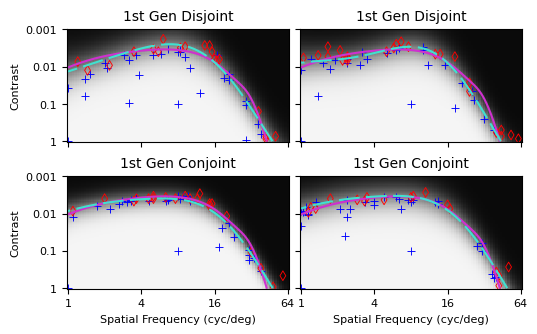

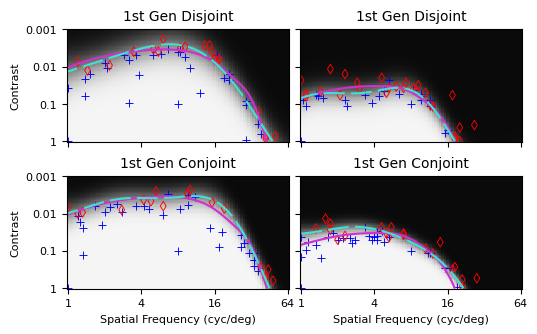

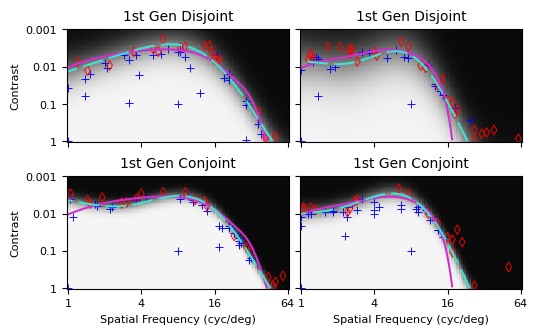

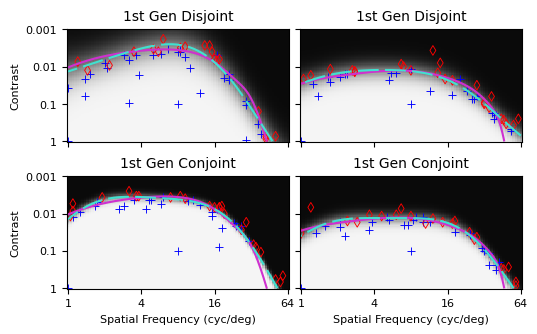

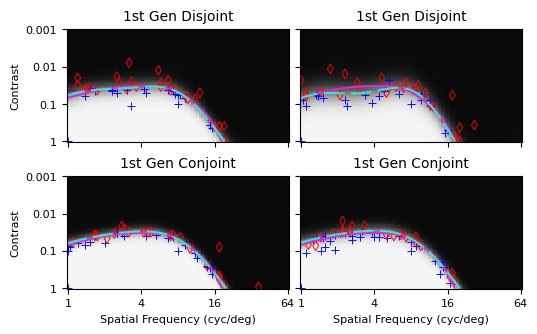

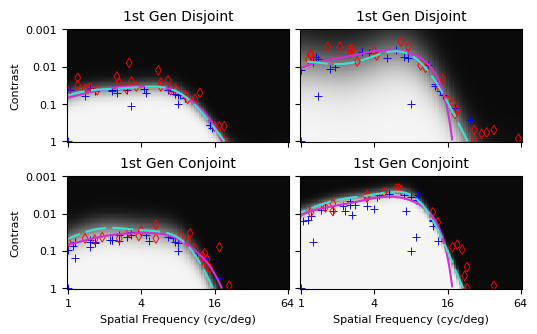

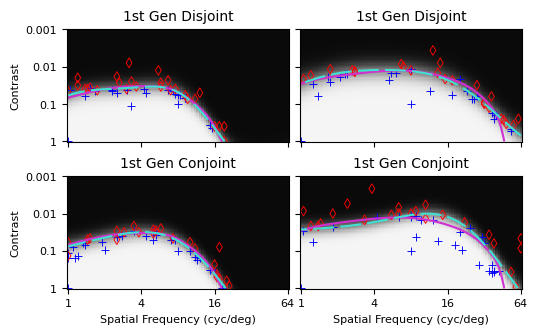

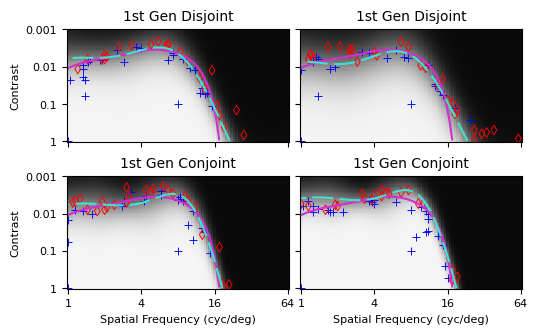

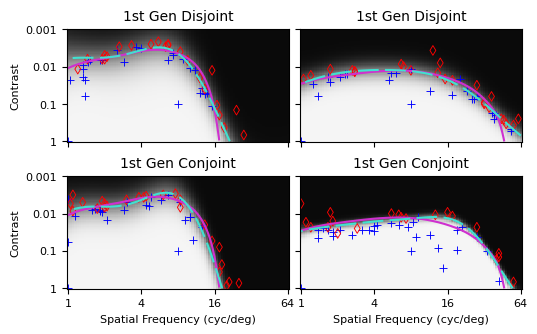

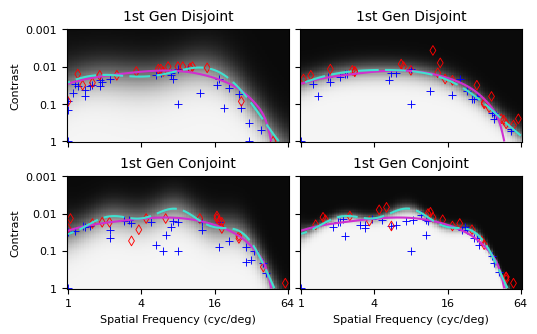

In [29]:
%matplotlib inline
plt.tight_layout()

# plot final model for each experiment
for exp in range(num_exps):
    for pair_names_and_curves in all_pairs_names_and_curves:
        pair_names = (pair_names_and_curves[0][0], pair_names_and_curves[1][0])
        print(pair_names)
        pair_dir = '__'.join(pair_names).replace(' ', '_')
        
        primer_seeds = primer_seeds_list[exp]
    
        # Create a 2x2 grid for subplots
        fig, axs = plt.subplots(2, num_tasks, figsize=(figure_width, figure_height))
    
        # create grid and posterior
        grid_transformed = transform_dataset(grid, phi=normalize_to_unit_range)
    
        # get experiment-specific data
        # model = all_conjoint_gp_lists_old[pair_names][exp][-1]
        X = all_conjoint_results_dicts_old[pair_names][exp]['X']
        y = all_conjoint_results_dicts_old[pair_names][exp]['y']
        task_indices = all_conjoint_results_dicts_old[pair_names][exp]['task_indices']
        zz = all_conjoint_results_dicts_old[pair_names][exp]['zz']
    
        for i, (pheno, _) in enumerate(pair_names_and_curves):
            ax = axs[1, i]
    #         title = f"{pheno} cMLCRF1.0  (seed {primer_seeds[i]})"
            title = titles['conjoint'][i]
    
            # get posterior
            grid_indices = torch.from_numpy(np.repeat(i, grid_transformed.shape[0]).astype(np.int64))
    
            # get task-specific data
            task_X = X[task_indices == i, :]
            task_y = y[task_indices == i]
            task_zz = zz[:,:,i]
            ground_truth = all_ground_truths[pair_names][i]
    
            # load data from results 
            conjoint_results_dict_old = {
                'X': task_X,
                'y': task_y,
                "xx": xx,
                "yy": yy,
                "zz": task_zz,
                "cs": ground_truth,
                "psi_gamma": psi_gamma,
                "psi_lambda": psi_lambda,
                "x_min": x_min,
                "x_max": x_max,
                "y_min": y_min,
                "y_max": y_max,
                "xs": xs,
                "ys": ys
            }
    
            create_gp_plot(
                ax, 
                conjoint_results_dict_old, 
                title,
                title_font_size=title_font_size,
                label_font_size=label_font_size,
                tick_font_size=tick_font_size,
                line_width=line_width,
                marker_size=marker_size,
                marker_line_width=marker_line_width
            )
            ax.label_outer()
    
        # Second Snippet Plotting in Second Row
        for task_idx, (pheno, _) in enumerate(pair_names_and_curves):
            # get experiment-specific data from the second snippet
            # model = all_disjoint_gp_lists_old[pair_names][task_idx][-1]
            X = all_disjoint_results_dicts_old[pair_names][task_idx][exp]['X']
            y = all_disjoint_results_dicts_old[pair_names][task_idx][exp]['y']
            zz = all_disjoint_results_dicts_old[pair_names][task_idx][exp]['zz']
    
            ax = axs[0, task_idx]
    #         title = f"{pheno} dMLCRF1.0 (seed {primer_seeds[task_idx]})"
            title = titles['disjoint'][i]
    
            # load data from results 
            disjoint_results_dict_old = {
                'X': X,
                'y': y,
                "xx": xx,
                "yy": yy,
                "zz": zz,
                "cs": all_ground_truths[pair_names][task_idx],
                "psi_gamma": psi_gamma,
                "psi_lambda": psi_lambda,
                "x_min": x_min,
                "x_max": x_max,
                "y_min": y_min,
                "y_max": y_max,
                "xs": xs,
                "ys": ys
            }
    
            create_gp_plot(
                ax, 
                disjoint_results_dict_old, 
                title, 
                title_font_size=title_font_size,
                label_font_size=label_font_size,
                tick_font_size=tick_font_size,
                line_width=line_width,
                marker_size=marker_size,
                marker_line_width=marker_line_width
            )
            ax.label_outer()
    
        # overall figure settings
    #     fig.suptitle(f"Disjoint vs Conjoint Experiment {exp}")
        plt.setp(axs, xticks=x_tick_values, xticklabels=x_tick_labels, yticks=y_tick_values, yticklabels=y_tick_labels)
    
        fig.subplots_adjust(**subplots_adjust_params)
    
        
        # TODO: Add a colorbar as needed
    
        # save and show
        if save_plots_mode:
            ensure_directory_exists(f'{save_dir}{pair_dir}/')
            exp_details = ""
            # Saving logic for the combined plot
            plt.savefig(f"{save_dir}{pair_dir}/Figure02_Disjoint1vsConjoint1-{pair_dir}.png", bbox_inches='tight', dpi=dpi_val)
            plt.savefig(f"{save_dir}{pair_dir}/Figure02_Disjoint1vsConjoint1-{pair_dir}.pdf", bbox_inches='tight', dpi=dpi_val)
    
        if scrn_mode:
            fig.show()
        else:
            plt.clf()


In [30]:
rmses_for_pairs = {pair:{} for pair in all_pairs_names}
for pair, d in rmses_for_pairs.items():
    disjoint_0 = all_disjoint_results_dicts_old[pair][0][0]['rmse_list'][-1]
    disjoint_1 = all_disjoint_results_dicts_old[pair][1][0]['rmse_list'][-1]
    conjoint_0 = all_conjoint_results_dicts_old[pair][0]['rmse_list'][0][-1]
    conjoint_1 = all_conjoint_results_dicts_old[pair][0]['rmse_list'][1][-1]
    d['disjoint_0'] = disjoint_0
    d['disjoint_1'] = disjoint_1
    d['conjoint_0'] = conjoint_0
    d['conjoint_1'] = conjoint_1

    print(f'################ {pair} #################')
    print(f'Disjoint 0: {disjoint_0}')
    print(f'Disjoint 1: {disjoint_1}')
    print(f'Conjoint 0: {conjoint_0}')
    print(f'Conjoint 1: {conjoint_1}')

if save_results_mode:
    ensure_directory_exists(save_dir)
    with open(f'{save_dir}rmses_for_pairs.json', 'w') as file:
        json.dump({str(key): value for key, value in rmses_for_pairs.items()}, file, indent=2)

################ ('Normal', 'Normal') #################
Disjoint 0: 0.12287317397523957
Disjoint 1: 0.14221300559162514
Conjoint 0: 0.09468429365645642
Conjoint 1: 0.08215436769194599
################ ('Normal', 'Cataracts') #################
Disjoint 0: 0.12287317397523957
Disjoint 1: 0.09222910365917003
Conjoint 0: 0.10176168836639012
Conjoint 1: 0.16071437319304238
################ ('Normal', 'Mild Amblyopia') #################
Disjoint 0: 0.12287317397523957
Disjoint 1: 0.1404065569290984
Conjoint 0: 0.14903995791412467
Conjoint 1: 0.11381668091067423
################ ('Normal', 'Multiple Sclerosis') #################
Disjoint 0: 0.12287317397523957
Disjoint 1: 0.08668398697997942
Conjoint 0: 0.09198097127657011
Conjoint 1: 0.06362384569081846
################ ('Cataracts', 'Cataracts') #################
Disjoint 0: 0.03965199382990104
Disjoint 1: 0.09222910365917003
Conjoint 0: 0.0370108675405265
Conjoint 1: 0.04743078831421019
################ ('Cataracts', 'Mild Amblyopia') ####